# Readability of Text With Linguistic Features

The current readability measures for text include mostly the length of sentences combined with the syllable length of words, as well as some examples of the syntax used to start a sentence. This is not enough to accurately understand how difficult a text is, many long sentences can be syntactically simple. Some texts may use easy words despite difficult syntax. 

This notebook will uses linguistic attributes to extract syntactic, morphological and semantic features from text to create more accurate measurements of difficulties of text regardless of length. 

1. [Syntax](#syntax)
    1. [Subtree Measurements](#subtrees)
    2. [Constituency Node Complexity](#nodes)
2. [Morphology](#morph)
    1. [Dependencies](#deps)
    2. [Pronoun Measures](#pronouns)
    3. [Morphological Complexity](#tagtypes)
3. [Semantics](#sems)
    1. [Word Frequency](#wordfreq)
    2. [Lexical Diversity](#lexdiv)
    3. [Topic Modeling with LDA](#topicmodel)

In [2]:
# pip install benepar
# pip install boto3
# pip install wordfreq
# pip install lexical-diversity
# pip install readability

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from spacy import displacy 
import seaborn as sns
from collections import Counter
from wordfreq import word_frequency
from lexical_diversity import lex_div as ld
import readability
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.feature_extraction.text import TfidfVectorizer
import benepar
nlp = spacy.load('en_core_web_sm', disable = ['ner'])
if spacy.__version__.startswith('2'):
    nlp.add_pipe(benepar.BeneparComponent("benepar_en3"))
else:
    nlp.add_pipe("benepar", config={"model": "benepar_en3"})
import pickle

**Load data files**

In [4]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

**Make Dataframe with Old Readability Measures to Use as Baseline When Modeling**

In [5]:
results = []

for text in train.excerpt:
    scores = (readability.getmeasures([text], lang='en'))
    results.append(scores['readability grades']['FleschReadingEase'])

In [6]:
readability_results = pd.DataFrame({'results': results,
                                   'target':train['target']})
readability_results.head()

,results,target
0,-79.300279,-0.340259
1,-69.068256,-0.315372
2,-68.230294,-0.580118
3,-60.216463,-1.054013
4,-29.272041,0.247197


In [7]:
readability_results.to_csv('./data/old_readability_train.csv', index = False)

### Load in Training Data Which Was Already Run Through NLP Pipeline

In [8]:
#************** Uncomment to load train.pkl into your file *************************

# bucket = 'picklenlp'
# key = 'train.pkl'

# s3 = boto3.client(
#                  
#                  )

# s3.download_file(Filename = 'train.pkl',
#                      Bucket = bucket, 
#                      Key = key)

In [9]:
# Loading NLP versions of both files 

# run test data through pipeline 
test['excerpt'] = test['excerpt'].map(lambda x: nlp(x))

# open file from dir after loading from aws or compiling in Compile_Data.ipynb
file_to_read = open("train.pkl", "rb")
loaded_object = pickle.load(file_to_read)
file_to_read.close()

train['excerpt'] = np.array(loaded_object)

/opt/anaconda3/lib/python3.8/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +
<ipython-input-9-25945bf0ebe8>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train['excerpt'] = np.array(loaded_object)


**Saving the easiest and hardest sentences to use as reference**


In [10]:
hardest_sentence = train.sort_values('target').head(1)['excerpt'].values

easiest_sentence = train.sort_values('target', ascending=False).head(1)['excerpt'].values

In [11]:
#example of first sentence in easiest excerpt
[sent for sent in easiest_sentence[0].sents][0]

When you think of dinosaurs and where they lived, what do you picture?

In [12]:
#example of first sentence in hardest excerpt
[sent for sent in hardest_sentence[0].sents][:2]

[The commutator is peculiar, consisting of only three segments of a copper ring, while in the simplest of other continuous current generators several times that number exist, and frequently 120!,
 segments are to be found.]

# Initial EDA

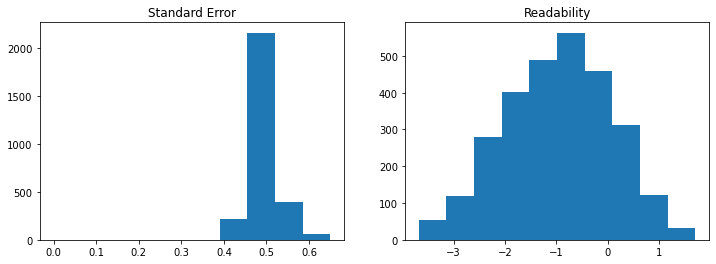

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].hist(train.standard_error)
ax[0].set_title('Standard Error')
ax[1].hist(train['target'])
ax[1].set_title('Readability');

**Interpretation**

It seems that the readability has a normal distribution. The range of standard deviation is cenetered at about .5. It would be useful to create a model that focuses on feature importance and see what features contribute the most to the variation in readability opinions.

**Looking at Range for Readability Values**

In [14]:
train[['target', 'standard_error']].describe()

,target,standard_error
count,2834.000000,2834.000000
mean,-0.959319,0.491435
std,1.033579,0.034818
min,-3.676268,0.000000
25%,-1.690320,0.468543
50%,-0.912190,0.484721
75%,-0.202540,0.506268
max,1.711390,0.649671


**Checking for Nulls**

In [15]:
train.isna().sum()

id                   0
url_legal         2004
license           2004
excerpt              0
target               0
standard_error       0
dtype: int64

**Get Average Sentence Length Per Excerpt**

In [16]:
def avg_length(text):
    
    '''
    Returns the average number of words per sentence in a text
    Paramets:
    text: nlp doc type
    '''
    num_sentences = 0
    total_words = 0
    for sentence in text.sents:
        num_sentences += 1
        total_words += len([word for word in sentence])
    avg = total_words / num_sentences
    return avg

train['avg_sent_length'] = train.excerpt.map(avg_length)
test['avg_sent_length'] = test.excerpt.map(avg_length)

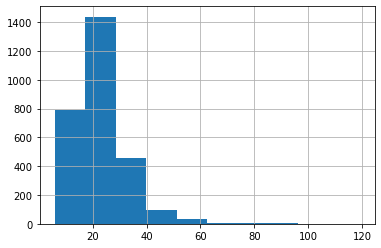

In [17]:
train.avg_sent_length.hist();

**Interpretation** 

The sentence length is left skewed, with some sentences having many more words. This could, with a combination of other features, be an indication of difficulty, however cannot be a factor on its own. 

**Exemplifying the fact that sentence length does not always mean the hardest sentence**

In [18]:
train[train.avg_sent_length == train.avg_sent_length.max()]['excerpt'].values[0]

Many of the other pictures were much too beautiful to begin with, especially before lunch, but as they were drawn over and over again on birch-bark, they became plainer and easier, till at last even Tegumai said he could find no fault with them. They turned the hissy-snake the other way round for the Z-sound, to show it was hissing backwards in a soft and gentle way; and they just made a twiddle for E, because it came into the pictures so often; and they drew pictures of the sacred Beaver of the Tegumais for the B-sound; and because it was a nasty, nosy noise, they just drew noses for the N-sound, till they were tired; and they drew a picture of the big lake-pike's mouth for the greedy Ga-sound; and they drew the pike's mouth again with a spear behind it for the scratchy, hurty Ka-sound; and they drew pictures of a little bit of the winding Wagai river for the nice windy-windy Wa-sound; and so on and so forth and so following till they had done and drawn all the sound-pictures that the

In [19]:
train[train.avg_sent_length == train.avg_sent_length.min()]['excerpt'].values[0]

Yuadoo is scared of the dark. Everyone feels fear sometimes. But Yuadoo can ask for help. Chidubem is worried about his schoolwork. He can tell his teacher. He can ask for help. Lushan is playing around! It's okay to be silly sometimes. Eruro is feeling sad. It's okay to cry. Emotions come and go. Ayator is bursting with happiness. He is joyful. Emotions come and go. Hadiza is bored. She needs to find something to do. Ayo is angry. He is frustrated. Anger is a difficult feeling. Labake is excited. What's the cause of her excitement? Mother made her favorite food. Zege felt sleepy. He was very tired. "But wait, is 'sleepy' an emotion?" asks Efe. Efe is confused! Can you answer his question? Tega is feeling surprise and shock. He heard some gossip. Is it true? Yebo is sick. She feels miserable. She needs some medicine and rest to feel better. Sekyen is feeling content. She has finished her chores. Now she can play. Vandefan does not have chores today. He shows two thumbs up to Sekyen. "G

<a id='syntax'></a>

# Syntax 

Measures: 
1. Subtrees by length and number per sentence. 
   - To measure syntactic complexity and tree depth of constituents in sentences with only spaCy.
   
2. Node Types:
    - Beyond the depth of the trees in the sentences, the unique types of nodes that head each tree are important, as well as the number of types. The more types of nodes, the more syntactically complex the sentence.
    
    
Further Steps: 
1. The splitting of auxiliary verbs in sentences.
    - For example: 'I am, tomorrow, going to the store.' 
    - Spacy's morphology and Benepar parsers come pretrained and therefore do not have the power to accurately understand when verbs are acting alone or as auxiliary verbs only connected over a wide span of other constituents. 
2. Node Shifting in cases with heavy Subjects, Direct Objects, and Prepositional Objects. 
    - Also known as Heavy Noun Phrase Shift. Example: 'I saw, next to the house, my large, black dog with my shoe in his mouth. 
    - This is also very difficult to measure due to the complexity of context which can surround the shifting. 

<a id='subtrees'></a>


## Subtrees

Measure the syntactic complexity of the text by the number and length of subtrees.

**Calculating number of subtrees per sentence subtrees**


In [20]:
def get_num_subtree(text):
    
    """
    Takes in a spaCy doc and returns the average number of subtrees per \
    sentence as a simple of measuring the syntactic complexity of the text
    
    Paramters: 
    text: nlp(text)
    
    Requirements: text must have attributes: Span.sents, token.subtree 
    
    """
    total_subtrees = 0 
    total_sentences = 0
    for sentence in text.sents:
        total_sentences += 1
        for token in sentence:
            total_subtrees += len([t for t in token.subtree])
    return total_subtrees/total_sentences

In [21]:
train['subtree_per_sent'] = train.excerpt.map(get_num_subtree)
test['subtree_per_sent'] = test.excerpt.map(get_num_subtree)

**Examining the excerpts with the max and min subtrees per sentence to check the function**

In [22]:
train[train['subtree_per_sent'] == train['subtree_per_sent'].max()]['excerpt'].values[0]

Many of the other pictures were much too beautiful to begin with, especially before lunch, but as they were drawn over and over again on birch-bark, they became plainer and easier, till at last even Tegumai said he could find no fault with them. They turned the hissy-snake the other way round for the Z-sound, to show it was hissing backwards in a soft and gentle way; and they just made a twiddle for E, because it came into the pictures so often; and they drew pictures of the sacred Beaver of the Tegumais for the B-sound; and because it was a nasty, nosy noise, they just drew noses for the N-sound, till they were tired; and they drew a picture of the big lake-pike's mouth for the greedy Ga-sound; and they drew the pike's mouth again with a spear behind it for the scratchy, hurty Ka-sound; and they drew pictures of a little bit of the winding Wagai river for the nice windy-windy Wa-sound; and so on and so forth and so following till they had done and drawn all the sound-pictures that the

**Calculating length (in words) of subtrees per sentence subtrees**

In [23]:
def get_len_subtree(text):
    
    """
    Takes in a spaCy doc and returns the average length of subtrees per \
    sentence as a simple of measuring the syntactic complexity of the text
    
    Paramters: 
    text: nlp(text)
    
    Requirements: text must have attributes: Span.sents, token.subtree 
    
    """
    total_subtrees = 0 
    len_subtrees = 0
    for sentence in text.sents:
        for token in sentence:
            total_subtrees += len([t for t in token.subtree])
            len_subtrees += sum(len(t) for t in token.subtree)
    if total_subtrees !=0:
        return len_subtrees/total_subtrees
    else: 
        return 0

In [24]:
train['subtree_len'] = train.excerpt.map(get_len_subtree)
test['subtree_len'] = test.excerpt.map(get_len_subtree)

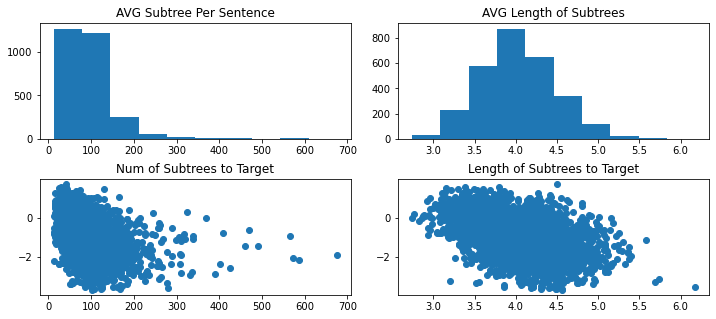

In [25]:
fig, ax = plt.subplots(nrows=2, ncols = 2, figsize = (12, 5))

ax[0][1].hist(train['subtree_len'])
ax[0][1].set_title('AVG Length of Subtrees')
ax[1][1].scatter(train['subtree_len'], train.target)
ax[1][1].set_title('Length of Subtrees to Target')

ax[0][0].hist(train['subtree_per_sent'])
ax[0][0].set_title('AVG Subtree Per Sentence')
ax[1][0].scatter(train['subtree_per_sent'], train.target)
ax[1][0].set_title('Num of Subtrees to Target')
fig.subplots_adjust(hspace=0.35, wspace=0.15);

In [26]:
# making a column that is the number of subtrees by the length within them

train['subtree_len_by_num'] = train.subtree_len*train.subtree_per_sent
test['subtree_len_by_num'] = test.subtree_len*train.subtree_per_sent

**Notes**

The idea was that the more subtrees in each sentence, the more difficult it would be to read. It seems that there is a general correlation that might be more linear with its interaction with other features.

<a id='nodes'></a>

## Node Complexity

**Calculating the number of unique nodes that start each constituency parsing.**

In [27]:
def node_types(text):
    
    '''
    Returns the average number of unique nodes per text to measure the syntactic complexity. 
    
    Parameters: 
    text: doc with Benepar (Berkeley Neural Parser) ._.labels attribute 
    '''
    
    nodes = 0
    labels = set()
    for word in text:
        if word._.labels:  # exclude empty nodes that look like () 
            nodes +=1
            labels.add(word._.labels)
    return len(labels)/nodes

In [28]:
train['node_types'] = train.excerpt.map(node_types)
test['node_types'] = test.excerpt.map(node_types)

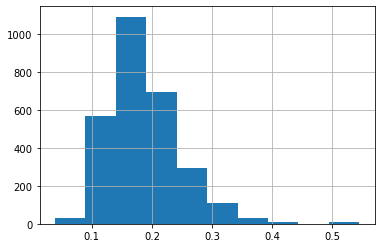

In [29]:
train.node_types.hist();

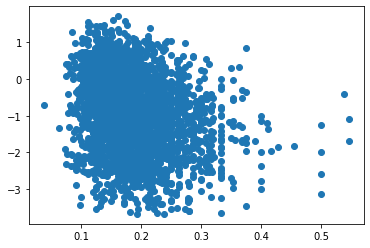

In [30]:
plt.scatter(train['node_types'], train['target']);

<a id='morph'></a>

# Morphology 

Measures:

1. Dependencies: number per word, distance, location. 
    - The more dependencies that exist per word, the more cognitive load will exist on the reader's short term memory, especially if those dependencies show up before the word itself and are separated from the dependent word by many words. 

2. The ratio of nouns and pronouns to proper nouns. 
    - Overuse of pronouns in a sentence when there are many possibilities of which noun is being referenced can make text more readable. In future versions, this ratio will be improved by using [nueralcoref](https://github.com/huggingface/neuralcoref) to measure the pronouns and possibile confusion caused by their dependencies.
    
3. Morphological Complexity
     - The number of unique tags and dependencies used in each sentence. 

<a id='deps'></a>


## Number of Dependencies per Token

In [31]:
def avg_dep(text, dep_type, n_left = False, n_right = False):
    
    """
    Returns the average number children of a certain dependency type per sentence, 
    or the number of children to the left or right of the token 

    Paramters: 
        nlp(text): spaCy Doc type text 
        n_left = False : count only dependencies to the left of the token
        n_right = False : count only dependencies to the right of the token


    Requirements: text must have spaCy token.dep_ and token.children, token.n_lefts attributes 
    """
    
    total = 0
    dep = 0
    for token in text:
        if token.dep_ in dep_type:
            total += 1
            if n_left == True: 
                dep += token.n_lefts
            if n_right == True:
                dep += token.n_rights
            else:
                dep += len([child for child in token.children])

    if total != 0:
        return dep/total
    else:
        return 0

**Mapping the function as the left, right, and total dependencies to examine the distribution and make a determination on which to use in modeling**

In [32]:
# Left dependencies 

train['left_dep'] = train.excerpt.map(
    lambda x: avg_dep(text = x, 
                      dep_type =['nsubj', 'nsubjpass', 'ROOT', 'dobj'],
                      n_left = True))

test['left_dep'] = test.excerpt.map(
    lambda x: avg_dep(text = x, 
                      dep_type = ['nsubj', 'nsubjpass', 'ROOT', 'dobj'],
                      n_left = True))

In [33]:
# Right dependencies 

train['right_dep'] = train.excerpt.map(
    lambda x: avg_dep(text = x,
                      dep_type = ['nsubj', 'nsubjpass', 'ROOT', 'dobj'], 
                      n_right = True))

test['right_dep'] = test.excerpt.map(
    lambda x: avg_dep(text = x,
                      dep_type = ['nsubj', 'nsubjpass', 'ROOT', 'dobj'],
                      n_right = True))

In [34]:
# Total dependencies

train['total_dep'] = train.excerpt.map(
    lambda x: avg_dep(text = x,
                      dep_type = ['nsubj', 'nsubjpass', 'ROOT', 'dobj']))

test['total_dep'] = test.excerpt.map(
    lambda x: avg_dep(text = x,
                      dep_type = ['nsubj', 'nsubjpass', 'ROOT', 'dobj']))

## Distance from Dependencies

In [35]:
def avg_dep_distance(text, total = True, left=False, right=False):
    
    '''
    Returns the average number of words between a token and it's children
    
    Paramters: 
    text: spaCy doc - nlp(text)
    total = True: default, returns distance regardless of orientation to left or right
    left = False: returns distance of only a token's left children
    right = False: returns distance of only a token's right children
    '''
    
    tot_left_tokens = 0
    tot_right_tokens = 0
    left_distance = 0
    right_distance = 0

    for sentence in text.sents:

        for token in sentence:
            left_tokens = [word.i for word in token.lefts]
            right_tokens = [word.i for word in token.rights]
            tot_left_tokens += len(left_tokens)
            tot_right_tokens += len(right_tokens)
                #iterate through sentence at the token's index and count words between that index and the token 
            left_distance += sum([token.i - index for index in left_tokens])
            right_distance += sum([index - token.i for index in right_tokens])
    
    if total == True:
        return (left_distance+right_distance)/(tot_left_tokens+tot_right_tokens)
    if left == True:
        return (left_distance)/(tot_left_tokens)
    if right == True:
        return (right_distance)/(tot_right_tokens)

**Mapping the function as the left, right, and total dependency distances to examine the distribution and make a determination on which to use in modeling**

In [36]:
#left and right dependency distances 

train['left_dep_dist'] = train['excerpt'].map(
    lambda x: avg_dep_distance(x, total = False, left = True))

train['right_dep_dist'] = train['excerpt'].map(
    lambda x: avg_dep_distance(x, total = False, right = True))


test['left_dep_dist'] = test['excerpt'].map(
    lambda x: avg_dep_distance(x, total = False, left = True))

test['right_dep_dist'] = test['excerpt'].map(
    lambda x: avg_dep_distance(x, total = False, right = True))


In [37]:
#total dependency distances 
train['dep_dist'] = train['excerpt'].map(lambda x: avg_dep_distance(x))
test['dep_dist'] = test['excerpt'].map(lambda x: avg_dep_distance(x))

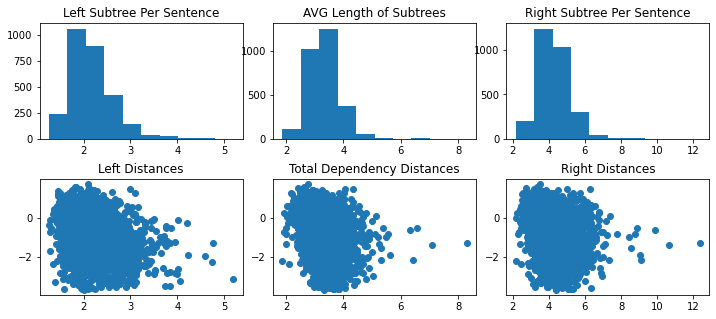

In [38]:
fig, ax = plt.subplots(nrows=2, ncols = 3, figsize = (12, 5))

ax[0][1].hist(train['dep_dist'])
ax[0][1].set_title('AVG Length of Subtrees')
ax[1][1].scatter(train['dep_dist'], train.target)
ax[1][1].set_title('Total Dependency Distances')

ax[0][0].hist(train['left_dep_dist'])
ax[0][0].set_title('Left Subtree Per Sentence')
ax[1][0].scatter(train['left_dep_dist'], train.target)
ax[1][0].set_title('Left Distances')

ax[0][2].hist(train['right_dep_dist'])
ax[0][2].set_title('Right Subtree Per Sentence')
ax[1][2].scatter(train['right_dep_dist'], train.target)
ax[1][2].set_title('Right Distances')
fig.subplots_adjust(hspace=0.35, wspace=0.15);

It is nearly impossible for now to tell which has more importance in terms of the text's readability. Because there seem to be slighlty higher dispersions in the left, and right dependencies, they might be a better indicator. 

Additionally, the option to separate left and right was to allow further preprocessing that analyzed the synactic makeup up left vs right nodes and the effect on the readability. 

**Looking into words with the largest distance between dependencies**

In [40]:
doc = train[train.dep_dist==train.dep_dist.max()]['excerpt'].values[0]
sentence = [sent for sent in doc.sents]
# displacy.serve(sentence, style="dep")
# print(sentence)

<a id='pronouns'></a>


## Pronouns Per Noun

In [39]:
def get_pronoun_ratio(text):
    
    """
    Paramters: doc of nlp(text) type
    
    Requirements: doc must have token.pos_ type

    returns the use-ratio of proper names and nouns, like 'Tokyo' and 'the cat' 
    to pronouns such as 'It, they, she, him'
    """
   
    propn = 0
    pron = 0
    for word in text: 
        if word.pos_ == 'PRON' and word.morph.get('Person') == ['3']:
            pron += 1
        if word.pos_ == 'PROPN' or word.pos_ == 'NOUN' and word.dep_ in ['subj', 
                                                                        'dobj',
                                                                         'nsubjpass',
                                                                         'pobj']:
            propn += 1
    return pron/propn

In [40]:
train['pron_ratio'] = train['excerpt'].map(get_pronoun_ratio)
test['pron_ratio'] = test['excerpt'].map(get_pronoun_ratio)

In [41]:
train[train['pron_ratio'] == train['pron_ratio'].max()]['excerpt'].values[0]

ALL that a man achieves and all that he fails to achieve is the direct result of his own thoughts. In a justly ordered universe, where loss of equipoise would mean total destruction, individual responsibility must be absolute. A man's weakness and strength, purity and impurity, are his own, and not another man's; they are brought about by himself, and not by another; and they can only be altered by himself, never by another. His condition is also his own, and not another man's. His suffering and his happiness are evolved from within. As he thinks, so he is; as he continues to think, so he remains.
A strong man cannot help a weaker unless that weaker is willing to be helped, and even then the weak man must become strong of himself; he must, by his own efforts, develop the strength which he admires in another. None but himself can alter his condition.

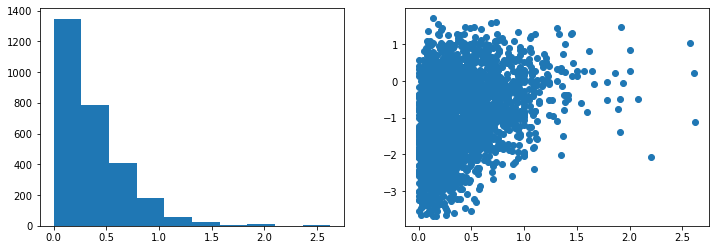

In [42]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].hist(train['pron_ratio'])
ax[1].scatter(train['pron_ratio'], train['target']);

**Interpretaiton**

It is surprising to see that the more pronouns there are per text, contrary to my hypothesis, the easier the text is to read. Perhaps this is due to dialouges, which could contribute to easier reading and would need to be modeled. Another explanation is that perhaps there is only one main subject in the text and therefore the pronouns are not confusing. 

This ratio does not measure pronoun co-reference which is what was attempted to be extracted from this function. Implementation of nueralcoref could help parse a more accurate picture of reading complexity stemming from pronoun usage.

## Use of Perfect Tense in Verbs 

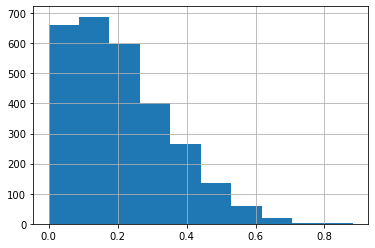

In [44]:
def count_perfect(text):
    '''
    Returns the average use of perfect tense to verbs in the text
    
    Parameters:
    text: Doc of nlp(text)
    
    '''
    doc = text
    words = [word.pos_ for word in doc if word.pos_ in ('VERB')]
    total_verbs = len(words)
    aux = len([word for word in doc if 
                 word.morph.get('Aspect') == ['Perf']])
    
    
    return aux/total_verbs

train['perf_verbs'] = train.excerpt.map(count_perfect)

test['perf_verbs'] = test.excerpt.map(count_perfect)

train['perf_verbs'].hist();

In [45]:
train[train['perf_verbs'] == train['perf_verbs'].max()]['excerpt'].values[0]

From September 26, 1882, to September 1, 1883, night and day uninterruptedly, a watch was kept, in which the officers took part, so that the observations might be regularly made and recorded. Every four hours a series of direct magnetic and meteorological observations was made, from hour to hour meteorological notes were taken, the rise and fall of the sea recorded, and these were frequently multiplied by observations every quarter of an hour; the longitude and latitude were exactly determined, a number of additions to the catalogue of the fixed stars for the southern heavens made, and numerous specimens in natural history collected.
The apparatus employed by the expedition for the registration of the magnetic elements was devised by M. Mascart, by which the variations of the three elements are inscribed upon a sheet of paper covered with gelatine bromide, inclination, vertical and horizontal components, with a certainty which is shown by the 330 diurnal curves brought back from the Ca

<a id='tagtypes'></a>


## Complexity of Morphological Types

**Calculating the count of unique types of morphological words used in the text as some tags, like specific types of conjunctions, will contribute to more difficult readability**

In [46]:
def count_tag_typ(text):
    
    '''    
    Paramters: 
    nlp(text): Doc of spaCy nlp type 
    
    Returns a dictionary with
        Keys each tag type in the text: does not include (PUNCT, X, SYM, SPACE, SUM or INTJ, 
        'HYPH', '.', 'FW', '-LRB-', ':', 'LS', 'SYM', '``','-RRB-', 'UH', 'CD').
        Values of the average use of each tag per word not in the omitted list
     '''
    
    tag_types = {}
    words = [word.tag_ for word in text if word.pos_ not in [
        'PUNCT','X','SPACE','SYM','NUM','INTJ'] and word.tag_ not in [
        'HYPH', '.', 'FW', '-LRB-', ':', 'LS', 'SYM', '``','-RRB-', 'UH', 'CD']]

    count = Counter(words)
    total = len(words)
    return count


train['num_tags'] = train['excerpt'].map(lambda x: count_tag_typ(x))
test['num_tags'] = test['excerpt'].map(lambda x: count_tag_typ(x))

**Creating a new data frame from the function to clean and add into the main data after**

In [47]:
tags_train = pd.DataFrame([tag for tag in train['num_tags']])
tags_test = pd.DataFrame([tag for tag in test['num_tags']])

After checking the number of nulls per dataset, I decided to fill all in order to make the dataset generalizable to any text that may be run through the model.

In [48]:
tags_train = tags_train.fillna(0)
tags_test = tags_test.fillna(0)

**Concatenating the tag data frame and the main dataframe**

In [49]:
train = pd.concat([train, tags_train], axis = 1)
test = pd.concat([test, tags_test], axis = 1)

train.drop(columns = ['num_tags'], inplace = True)
test.drop(columns = ['num_tags'], inplace = True)

**Counting the set of tags and dependencies to get an idea of how morphologically rich each excerpt is**

In [50]:
def count_tags(text):

    '''
    Returns the average number of unique tag_ per sentence
    
    Paramters: 
    nlp(text): a spaCy doc type
    '''
    sentences = 0
    sent_tags = 0

    for sentence in text.sents:
        sentences += 1
        sent_tags += len(set([word.tag_ for word in sentence]))

    return(sent_tags/sentences)

In [51]:
def count_deps(text):

    '''
    Returns the average number of unique dep_ per sentence
    
    Paramters: 
    nlp(text): a spaCy doc type
    '''
    sentences = 0
    sent_deps = 0

    for sentence in text.sents:
        sentences += 1
        sent_deps += len(set([word.dep_ for word in sentence]))

    return(sent_deps/sentences)

In [52]:
train['unique_tags'] = train.excerpt.map(lambda excerpt: 
                                                count_tags(excerpt))

test['unique_tags'] = test.excerpt.map(lambda excerpt: 
                                              count_tags(excerpt))

train['unique_deps'] = train.excerpt.map(lambda excerpt: 
                                                count_deps(excerpt))

test['unique_deps'] = test.excerpt.map(lambda excerpt: 
                                              count_deps(excerpt))

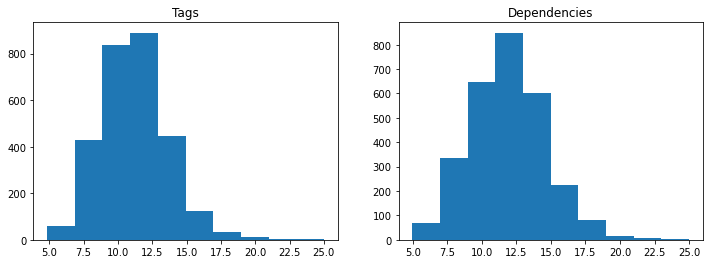

In [53]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].hist(train['unique_tags'])
ax[0].set_title('Tags')
ax[1].hist(train['unique_deps'])
ax[1].set_title('Dependencies');

**Interpretation**

Unique tags and dependencies are both normally distributed which could be useful in predicting the target. The dependencies have a more uniform distribution though so it will be the default feature used in the model unless there is a strong difference between the two.

In [54]:
train[train['unique_deps']==train['unique_deps'].max()]['excerpt'].values[0]

Now and then there are truths of a higher kind than these in Franklin, and Sainte-Beuve, the great French critic, quotes, as an example of his occasional finer moods, the saying, "Truth and sincerity have a certain distinguishing native luster about them which cannot be counterfeited; they are like fire and flame that cannot be painted." But the sage who invented the Franklin stove had no disdain of small utilities; and in general the last word of his philosophy is well expressed in a passage of his Autobiography: "Human felicity is produced not so much by great pieces of good fortune, that seldom happen, as by little advantages that occur every day; thus, if you teach a poor young man to shave himself and keep his razor in order, you may contribute more to the happiness of his life than in giving him a thousand guineas."

<a id='sems'></a>

# Semantics

Measures: 

1. Word Frequency 
    - using [wordfreq](https://pypi.org/project/wordfreq/) to measure the frequnecy a word occurs in the English langauge. The less often a word occurs, the less familiar it is to the reader. This may be the most subject to readability standard deviation. 
2. Lexical Diversity 
    - using [lexical-diversity](https://pypi.org/project/lexical-diversity/) to calculate how many stemmed words are in each text. The more words there are in the text (especially low frequency words) the harder it will be to interpret the entire text for some readers. 
3. Sentence Topics
    - LDA with 5 components will be anaylzed to see if the topics effect the readability of text. Particularly, these topcis combined with the word levels used within them may have a greater impact. 

<a id='wordfreq'></a>

## Word Frequency

Average word frequency will be calculated only on nouns, verbs, adjectives and adverbs due to the high frequency and the few options of words like pronouns, prepositions, etc. Inclusions of these words will oversaturate the frequency calcuations of the words.

Lexical diversity will be calculated on the same word types, however the words will be lemmatized so as to calculate the specific semantics used regardless of morphological aspects of the word. 

In [55]:
# find average english frequency of use of 
# noun, verb, adjective and adverbs in text in the text 

def avg_word_freq(text):
    
    '''
    Returns average word frequency (compared to use in English Language) of 
    noun, verb and adjective/adverbs in the document.
    Parameters: 
    text: spaCy Doc type
    '''
    
    total_words = 0
    word_freq = 0
    include = ['VERB', 'AUX', 'NOUN', 'ADV', 'ADJ']
    words = [word.text for word in text if word.pos_ in include]
    for word in words:
        total_words += 1
        word_freq += word_frequency(word, 'en')
    return word_freq/total_words

train['avg_word_freq'] = train.excerpt.map(avg_word_freq)
test['avg_word_freq'] = test.excerpt.map(avg_word_freq)

**Examining excerpts with the highest frequency(easiest words) and the lowest (hardest words)**

In [56]:
train[train['avg_word_freq'] == train['avg_word_freq'].max()]['excerpt'].values[0]

It is sad but true. Autumn is often called the sad time of the year, and it is the sad time. But it shouldn't be. Old Mother Nature never intended that it should be. She meant it to be the glad time. It is the time when all the little people of the Green Forest and the Green Meadows have got over the cares and worries of bringing up families and teaching their children how to look out for themselves. It is the season when food is plentiful, and every one is fat and is, or ought to be, care free. It is the season when Old Mother Nature intended all her little people to be happy, to have nothing to worry them for the little time before the coming of cold weather and the hard times which cold weather always brings.

In [57]:
train[train['avg_word_freq'] == train['avg_word_freq'].min()]['excerpt'].values[0]

In May 1774, in retaliation for the "Boston Tea Party," Parliament closed the port of Boston and virtually abolished provincial self-government in Massachusetts. These actions stimulated resistance across the land. That summer, the Massachusetts lower house, through the committees of correspondence, secretly invited all 13 Colonies to attend a convention. In response, on the fifth of September, 55 Delegates representing 12 Colonies, Georgia excepted, assembled at Philadelphia. They convened at Carpenters' Hall and organized the First Continental Congress.
Sharing though they did common complaints against the Crown, the Delegates propounded a wide variety of political opinions. Most of them agreed that Parliament had no right to control the internal affairs of the Colonies. Moderates, stressing trade benefits with the mother country, believed Parliament should continue to regulate commerce. Others questioned the extent of its authority. A handful of Delegates felt the answer to the prob

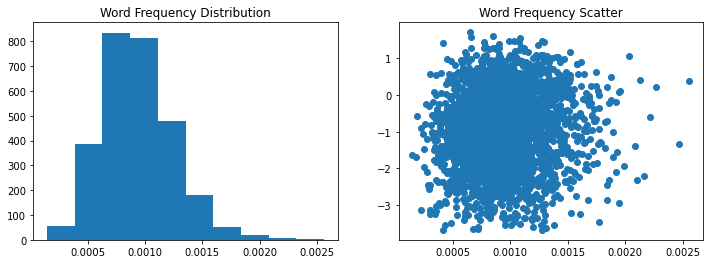

In [58]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].hist(train['avg_word_freq'])
ax[0].set_title('Word Frequency Distribution')
ax[1].scatter(train['avg_word_freq'], train.target)
ax[1].set_title('Word Frequency Scatter');

In [59]:
train.corr()[['target']].sort_values('target').loc['avg_word_freq']

target    0.100853
Name: avg_word_freq, dtype: float64

**Interpretation**

The almost perfect normal distribution indicated this could be a good feature to model on, although the scatter plot is quite wide. There seems to be a loose positive correlation between word frequency and readability. The distribution is quite wide within the scatter plot so it could be strengthen with interactions of other features. 

<a id='lexdiv'></a>


## Lexical Diversity

In [60]:
def find_lexical_diversity(text):
    '''Returns the lexical diversity of lemmed text using ttr formula
    Parameters: 
    nlp(text), a spaCy doc '''
    lemmed = [word.lemma_ for word in text if word.pos_ in 
              ['VERB', 'AUX', 'NOUN', 'ADV', 'ADJ']]
    lexdiv = ld.ttr(lemmed)
    return lexdiv 

train['lexical_diversity'] = train.excerpt.map(find_lexical_diversity)
test['lexical_diversity'] = test.excerpt.map(find_lexical_diversity)

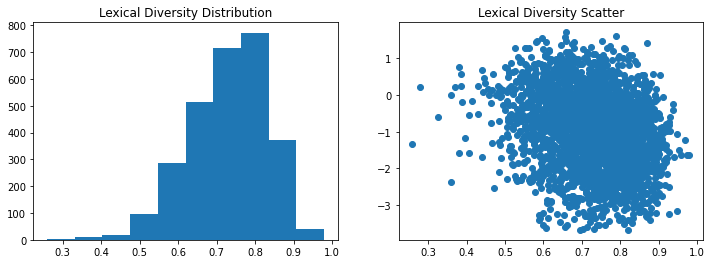

In [61]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].hist(train['lexical_diversity'])
ax[0].set_title('Lexical Diversity Distribution')
ax[1].scatter(train['lexical_diversity'], train.target)
ax[1].set_title('Lexical Diversity Scatter');

In [62]:
train.corr()[['target']].sort_values('target').loc['lexical_diversity']

target   -0.248186
Name: lexical_diversity, dtype: float64

**Interpretation**

As hypothesized, the more complex a text is lexically, the more difficult it becomes to read.

**Combining Word Frequency and Lexical Diversity**
How does a more diverse vocabulary that also holds less frequent words effect text compared to the two alone?

In [63]:
train['lexdiv_wordfreq'] = train[
    'avg_word_freq'] * train['lexical_diversity']

test['lexdiv_wordfreq'] = test[
    'avg_word_freq'] * test['lexical_diversity']

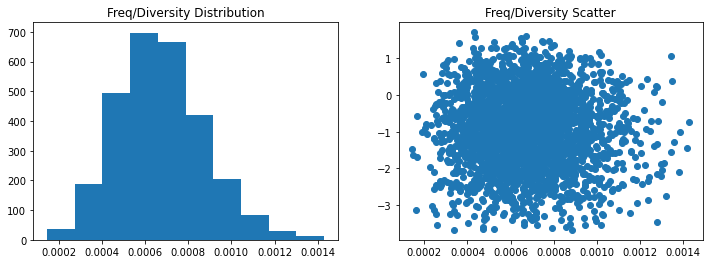

In [64]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].hist(train['lexdiv_wordfreq'])
ax[0].set_title('Freq/Diversity Distribution')
ax[1].scatter(train['lexdiv_wordfreq'], train.target)
ax[1].set_title('Freq/Diversity Scatter');

In [65]:
train.corr()[['target']].sort_values('target').loc['lexdiv_wordfreq']

target   -0.00391
Name: lexdiv_wordfreq, dtype: float64

**Interpretation**

It would make sense that the interaction of a positively and a negatively correlated feature would, on the surface level, cancel out the correlation. However, I will leave it in and perform manual selection when modeling to see the affects.

<a id='topicmodel'></a>


## Topic Modeling

**Lemmatizing words rather than stemming to preserve word form and interpretability**

In [66]:
stemmed_df_words = train.excerpt.map(lambda x: ' '.join([word.lemma_ for word in x]))
stemmed_test = test['excerpt'].map(lambda x: ' '.join([word.lemma_ for word in x]))

Converting data into a word vector matrix

In [67]:
tvec = TfidfVectorizer(stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 120,
                       max_df = .20,
                       norm = 'l2')

In [68]:
tvec.fit(stemmed_df_words)

lemmed_df = pd.DataFrame(tvec.transform(stemmed_df_words).todense(),
                  columns = tvec.get_feature_names())
lemmed_test = pd.DataFrame(tvec.transform(stemmed_test).todense(),
                  columns = tvec.get_feature_names())

**Creating the Topic Data with LDA**

In [69]:
#Code modified from Yanlin Chen | How to generate an LDA Topic Model for Text Analysis

lda_model = LatentDirichletAllocation(n_components= 5, 
                                      n_jobs = -1, 
                                      learning_method = 'online', random_state = 42)

lda_results = lda_model.fit_transform(lemmed_df)
lda_test = lda_model.transform(lemmed_test)

topicnames = ['Topic' + str(i) for i in range(5)]

topic_df = pd.DataFrame(lda_results, columns=topicnames)
topic_test = pd.DataFrame(lda_test, columns=topicnames)


In [70]:
#Code modified from Yanlin Chen | How to generate an LDA Topic Model for Text Analysis

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = tvec.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head()

,air,animal,ask,away,bear,begin,big,bird,body,boy,...,war,water,way,white,woman,word,work,world,year,young
Topic0,19.385975,0.202957,15.398220,48.337586,24.519474,35.088137,22.377617,36.015129,0.446085,18.113500,...,0.202893,42.030267,43.932152,31.523117,22.239418,9.539947,17.274575,14.373628,16.232413,22.569996
Topic1,0.231616,0.206602,41.449738,25.986475,23.333748,27.790069,23.159229,0.205570,0.201429,61.269186,...,0.215306,6.223016,24.859324,14.435536,22.401960,16.214268,31.285181,7.004020,39.865703,34.282691
Topic2,0.202119,1.330157,0.204408,0.212076,0.205774,0.205660,0.214849,0.202810,40.405056,0.201243,...,0.200456,0.204624,7.178529,0.271465,0.202736,0.285371,8.355472,0.210557,0.756994,0.203740
Topic3,40.386335,59.264319,1.759675,3.474970,4.422534,5.173858,14.249235,11.646575,8.502014,0.200995,...,0.200808,77.137747,11.209607,21.574187,0.202714,0.998609,4.526348,17.149659,23.339139,5.783613
Topic4,0.203578,0.329215,4.750221,3.554877,1.867253,11.337012,7.786422,0.200673,0.343012,0.201066,...,70.837125,0.222444,23.828898,0.204616,0.267924,32.222622,39.505813,43.849254,37.393510,5.543217


In [71]:
#Code modified from Yanlin Chen | How to generate an LDA Topic Model for Text Analysis

def show_topics(vectorizer=TfidfVectorizer, 
                lda_model=lda_model, n_words=5,
                learning_method = 'online'):
    keywords = np.array(tvec.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords


topic_keywords = show_topics(vectorizer=TfidfVectorizer, lda_model=lda_model, n_words=5)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4
Topic 0,man,look,foot,stand,tree
Topic 1,mother,mr,old,boy,play
Topic 2,brain,cell,body,different,matter
Topic 3,water,earth,animal,plant,food
Topic 4,people,war,power,state,country


In [72]:
topic_names = {'Topic0': 'Outdoors',
                      'Topic1':'Family',
                      'Topic2':'Science',
                      'Topic3':'Nature',
                      'Topic4':'War'}

topic_df.columns = topic_df.columns.map(topic_names)

topic_test.columns = topic_test.columns.map(topic_names)

**Final Preparation for Export and Modeling**

In [73]:
train = pd.concat([train, topic_df], axis=1)
test = pd.concat([test, topic_test], axis=1)

In [74]:
train = train.drop(columns = ['url_legal', 'license', 'excerpt'])
test = test.drop(columns = ['url_legal', 'license', 'excerpt'])

In [75]:
# plt.subplots(figsize=(30,30))
# sns.heatmap(train.corr(),
#             vmin = -1,
#             vmax = 1, 
#            annot = True);

In [76]:
train.to_csv('./data/train_cleaned.csv', index = False)
test.to_csv('./data/test_cleaned.csv', index = False)